In [1]:
import os, platform

distr = platform.dist()[0]

PATH = os.path.expanduser('~/datasets/letsdance') if distr == 'Ubuntu' else '/run/media/nast/DATA/letsdance' 
print("dataset path:", PATH)



/home/anton/datasets/letsdance


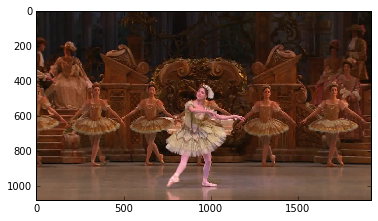

In [2]:
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

path = "letsdance_split/train/ballet/Et31LySAxf0_020_0266.jpg"
image = misc.imread(os.path.join(PATH, path))
plt.imshow(image)
plt.show()


In [6]:
import numpy
print(image.shape, np.amin(image), np.amax(image))

NameError: name 'np' is not defined